In [12]:
# Basic Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Clustering and Recommendation Libraries
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Saving Models
import joblib


In [5]:
data =pd.read_csv('/content/cleaned_data.csv')
df.dtypes


,0
invoice_id,int64
branch,object
city,object
category,object
unit_price,float64
quantity,float64
date,object
payment_method,object
rating,float64
profit_margin,float64


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_id      9969 non-null   int64  
 1   branch          9969 non-null   object 
 2   city            9969 non-null   object 
 3   category        9969 non-null   object 
 4   unit_price      9969 non-null   float64
 5   quantity        9969 non-null   float64
 6   date            9969 non-null   object 
 7   payment_method  9969 non-null   object 
 8   rating          9969 non-null   float64
 9   profit_margin   9969 non-null   float64
 10  total_price     9969 non-null   float64
 11  hour            9969 non-null   int64  
dtypes: float64(5), int64(2), object(5)
memory usage: 934.7+ KB
None
invoice_id        0
branch            0
city              0
category          0
unit_price        0
quantity          0
date              0
payment_method    0
rating            0
profit_margin 

In [10]:
df['date'] = pd.to_datetime(df['date'])

In [13]:
# Label Encoding for categorical variables
label_encoder = LabelEncoder()
categorical_cols = ['branch', 'city', 'category', 'payment_method']
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [14]:
# Standardize numerical features
scaler = StandardScaler()
numerical_cols = ['unit_price', 'quantity', 'rating', 'profit_margin']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [15]:
# Extract additional time-related features
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)


In [16]:
# Drop the original 'date' column
df = df.drop(columns=['date'])

In [17]:
# Check processed data
print(df.head())

   invoice_id  branch  city  category  unit_price  quantity  payment_method  \
0           1       2    83         3    1.135132  2.893030               2   
1           2      47    42         0   -1.666870  1.647215               0   
2           3      66    41         4   -0.202434  2.893030               1   
3           4      63     9         3    0.358344  3.515938               2   
4           5      12    46         5    1.683175  2.893030               2   

     rating  profit_margin  hour  day_of_week  is_weekend  
0  1.854783       0.951485    13            5           1  
1  2.138289       0.951485    10            4           0  
2  0.890865      -0.703149    13            6           1  
3  1.457876      -0.703149    20            6           1  
4 -0.299858       0.951485    10            4           0  


In [18]:
#Means for customer segmentation
customer_features = df[['rating', 'quantity', 'unit_price', 'profit_margin']]
kmeans = KMeans(n_clusters=3, random_state=42)
df['customer_segment'] = kmeans.fit_predict(customer_features)


In [20]:
from sklearn.cluster import KMeans

customer_segments = df['customer_segment']

segment_counts = customer_segments.value_counts()
print("Customer Segment Counts:\n", segment_counts)

segment_means = df.groupby('customer_segment')['unit_price'].mean()
print("\nMean Unit Price per Segment:\n", segment_means)

Customer Segment Counts:
 customer_segment
1    5005
0    4417
2     547
Name: count, dtype: int64

Mean Unit Price per Segment:
 customer_segment
0   -0.029149
1   -0.005615
2    0.286750
Name: unit_price, dtype: float64


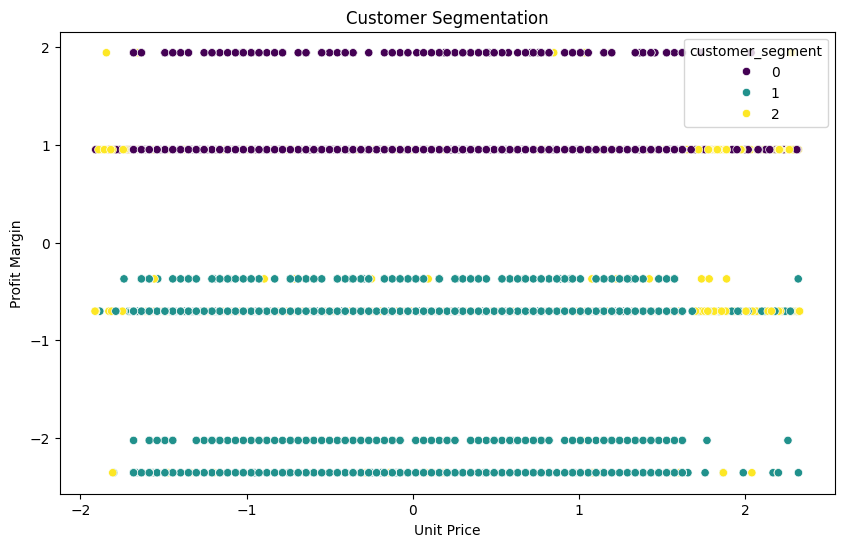

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_features, x='unit_price', y='profit_margin', hue=df['customer_segment'], palette='viridis')
plt.title("Customer Segmentation")
plt.xlabel("Unit Price")
plt.ylabel("Profit Margin")
plt.show()

In [21]:
joblib.dump(kmeans, 'customer_segmentation_model.pkl')


['customer_segmentation_model.pkl']

**Recommendation System**

In [26]:
# Pivot table for recommendation 
user_item_matrix = df.pivot_table(index='branch', columns='category', values='rating', aggfunc='mean').fillna(0)

similarity_matrix = cosine_similarity(user_item_matrix.T)  # Transpose the matrix to focus on categories

np.save('category_similarity_matrix.npy', similarity_matrix)

category_index = 0  # Replace with actual category index
similar_categories = similarity_matrix[category_index]
recommended_categories = np.argsort(similar_categories)[::-1][1:6]  # Top 5 similar categories
print("Top 5 Recommended Categories:", recommended_categories)


Top 5 Recommended Categories: [1 4 5 3 2]


In [91]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

X = df.drop(columns=['profit_margin'])
y = df['profit_margin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

print(X_train.isnull().sum())
print(X_val.isnull().sum())
print(y_train.isnull().sum())
print(y_val.isnull().sum())

print(X_train.columns)
print(X_val.columns)
.



(5981, 12) (1994, 12)
(5981,) (1994,)
invoice_id          0
branch              0
city                0
category            0
unit_price          0
quantity            0
payment_method      0
rating              0
hour                0
day_of_week         0
is_weekend          0
customer_segment    0
dtype: int64
invoice_id          0
branch              0
city                0
category            0
unit_price          0
quantity            0
payment_method      0
rating              0
hour                0
day_of_week         0
is_weekend          0
customer_segment    0
dtype: int64
0
0
Index(['invoice_id', 'branch', 'city', 'category', 'unit_price', 'quantity',
       'payment_method', 'rating', 'hour', 'day_of_week', 'is_weekend',
       'customer_segment'],
      dtype='object')
Index(['invoice_id', 'branch', 'city', 'category', 'unit_price', 'quantity',
       'payment_method', 'rating', 'hour', 'day_of_week', 'is_weekend',
       'customer_segment'],
      dtype='object')


**Model Training and Evaluation**

In [94]:
# Initialize models
rf_model = RandomForestRegressor(random_state=42)
xgb_model = xgb.XGBRegressor(random_state=42)
lgb_model = lgb.LGBMRegressor(random_state=42)


rf_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

xgb_param_dist = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

lgb_param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [20, 31, 50, 100],
    'min_data_in_leaf': [10, 20, 30, 50],
    'min_split_gain': [0.0, 0.1, 0.2],
    'max_depth': [-1, 5, 10, 15]
}

rf_random_search = RandomizedSearchCV(rf_model, param_distributions=rf_param_dist, n_iter=10,
                                      scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=1)
xgb_random_search = RandomizedSearchCV(xgb_model, param_distributions=xgb_param_dist, n_iter=10,
                                       scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=1)
lgb_random_search = RandomizedSearchCV(lgb_model, param_distributions=lgb_param_dist, n_iter=10,
                                       scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=1)

rf_random_search.fit(X_train, y_train)
xgb_random_search.fit(X_train, y_train)
lgb_random_search.fit(X_train, y_train)

best_rf = rf_random_search.best_estimator_
best_xgb = xgb_random_search.best_estimator_
best_lgb = lgb_random_search.best_estimator_

rf_predictions = best_rf.predict(X_val)
xgb_predictions = best_xgb.predict(X_val)
lgb_predictions = best_lgb.predict(X_val)

rf_rmse = mean_squared_error(y_val, rf_predictions, squared=False)
xgb_rmse = mean_squared_error(y_val, xgb_predictions, squared=False)
lgb_rmse = mean_squared_error(y_val, lgb_predictions, squared=False)

print(f"Random Forest RMSE: {rf_rmse:.4f}")
print(f"XGBoost RMSE: {xgb_rmse:.4f}")
print(f"LightGBM RMSE: {lgb_rmse:.4f}")

# Cross-validation RMSE
rf_cv_rmse = np.mean(cross_val_score(best_rf, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error'))
xgb_cv_rmse = np.mean(cross_val_score(best_xgb, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error'))
lgb_cv_rmse = np.mean(cross_val_score(best_lgb, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error'))

print(f"Random Forest CV RMSE: {rf_cv_rmse:.4f}")
print(f"XGBoost CV RMSE: {xgb_cv_rmse:.4f}")
print(f"LightGBM CV RMSE: {lgb_cv_rmse:.4f}")

def calculate_mase(y_true, y_pred, y_train):
    # Calculate naive forecast (previous value)
    naive_forecast = np.roll(y_true, 1)  # Use y_true instead of y_train
    naive_forecast[0] = y_true[0]  # Set first value to be the same for simplicity
    mae = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_true - naive_forecast))
    return mae / mae_naive
rf_mase = calculate_mase(y_val, rf_predictions, y_train)
xgb_mase = calculate_mase(y_val, xgb_predictions, y_train)
lgb_mase = calculate_mase(y_val, lgb_predictions, y_train)

print(f"Random Forest MASE: {rf_mase:.4f}")
print(f"XGBoost MASE: {xgb_mase:.4f}")
print(f"LightGBM MASE: {lgb_mase:.4f}")

best_model = None
best_rmse = min(rf_rmse, xgb_rmse, lgb_rmse)

if best_rmse == rf_rmse:
    best_model = 'Random Forest'
elif best_rmse == xgb_rmse:
    best_model = 'XGBoost'
else:
    best_model = 'LightGBM'

print(f"Best model based on RMSE: {best_model}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest RMSE: 0.0645
XGBoost RMSE: 0.0631
LightGBM RMSE: 0.0723
Random Forest CV RMSE: -0.0854
XGBoost CV RMSE: -0.0844
LightGBM CV RMSE: -0.0899
Random Forest MASE: 0.0049
XGBoost MASE: 0.0047
LightGBM MASE: 0.0103
Best model based on RMSE: XGBoost


In [95]:
import joblib

joblib.dump(best_xgb, 'best_xgb_model.pkl')


['best_xgb_model.pkl']